# 9-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

     * 한국어 텍스트의 감정분석
     * 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline

import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 읽어보기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print("train의 갯수 : ", len(train_data))
print("test의 갯수 : ", len(test_data))

train의 갯수 :  150000
test의 갯수 :  50000


## 2) 데이터로더 구성

    * 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면
      숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공했지만
      
    * 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어짐
    
    * 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작
    
    * data_loader 안에서는 다음을 수행해야 함
        * 데이터의 중복 제거
        * NaN 결측치 제거
        * 한국어 토크나이저로 토큰화
        * 불용어(Stopwords) 제거
        * 사전 word_to_index 구성
        * 텍스트 스트링을 사전 인덱스 스트링으로 변환
        * X_train, y_train, X_test, y_test, word_to_index 리턴

In [14]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    train_data.drop_duplicates(subset=['document'], inplace=True)   # 중복 제거
    train_data = train_data.dropna(how='any')                       # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')
    
    X_train = []    # train_data에서 'document'열만 뽑아서 리스트로 변환
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)   # 토큰화 = 문자열 형태의 단어들을 요소로 하는 리스트 반환
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)   # 리스트인 temp.X가 X_train의 한 요소로 들어감
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)   # 토큰화 = 문자열 형태의 단어들을 요소로 하는 리스트 반환
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)   # 리스트인 temp.X가 X_train의 한 요소로 들어감        
    
    words = np.concatenate(X_train).tolist() 
    # 왜 이런 형태로 썼는지는 모으겠음, 나중에 X_train이랑 words랑 뭐가 다른건지 print 해보면 좀 알듯
    counter = Counter(words)                 
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key,_ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}      # word : index 형태의 dict 생성
    
    def wordlist_to_indexlist(wordlist): # 입력 값인 wordlist에 있는 단어들을 index또는 <UNK> 로 변환해서 리스트에 담아 반환
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [15]:
# { word : index } 를 받아 { index : word } 로 뒤집음
index_to_word = {index:word for word, index in word_to_index.items()}

In [16]:
# 입력 : 문장 1개, 활용할 딕셔너리(데이터 사전)
# 출력 : 단어 인덱스 리스트 벡터
# 인 함수 정의
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
# .split() : 긴 문자열형 자료를 받아 짧은 단어의 문자열을 요소로 하는 리스트로 변경

# 여러 개의 문장을 받아 한꺼번어 단어 인덱스 리스트 벡터로 변경(함수명 끝에 s 추가)
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터를 입력 받아 원래 문장으로 바꿔 줌
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) # [1:]를 통해 <BOS>를 제외
    # ''.join() : ''안의 구분자를 기준으로 리스트를 문자열로 다시 합체(split의 반대 연산)
    
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]    

## 3) 모델구성을 위한 데이터 분석 및 가공
    * 데이터셋 내 문장 길이 분포
    * 적절한 최대 문장 길이 지정
    * keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


### 3-1. 데이터 셋 내 문장 길이 분포 확인

In [22]:
# 전체 문장 데이터에 대한 리스트 생성
total_data = X_train+X_test

num_tokens = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


### 3-2. 적절한 최대 문장 길이 지정

In [23]:
# 최대 길이를 (평균 + 2*표준편차)로 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됨'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됨


### 3-3. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [24]:
# 앞쪽 (pre) padding 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

print(X_train.shape)

(146182, 41)


##  모델구성 및 validation set 구성
    

* RNN 모델 구성

 * 모델 1

In [26]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()

# input_shape = (batch_size, input_length)
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8)) # LSTM state 벡터의 차원수 8
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍/부정을 나타내는 1 dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


 * 모델 2

In [ ]:
vocab_size = 5000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()

# input_shape = (batch_size, input_length)
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8)) # LSTM state 벡터의 차원수 8
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍/부정을 나타내는 1 dim

model.summary()

 * 모델 3

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()

# input_shape = (batch_size, input_length)
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8)) # LSTM state 벡터의 차원수 8
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍/부정을 나타내는 1 dim

model.summary()

*  모델 훈련 전에 train 데이터 중 10000개를 Validation set으로 사용

In [28]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 5. 모델 훈련

In [118]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2386 - accuracy: 0.9051 - val_loss: 0.3645 - val_accuracy: 0.8457
Epoch 2/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2194 - accuracy: 0.9136 - val_loss: 0.3684 - val_accuracy: 0.8495
Epoch 3/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1999 - accuracy: 0.9234 - val_loss: 0.3850 - val_accuracy: 0.8496
Epoch 4/20
266/266 [==============================] - 5s 19ms/step - loss: 0.1816 - accuracy: 0.9314 - val_loss: 0.4081 - val_accuracy: 0.8449
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1620 - accuracy: 0.9406 - val_loss: 0.4329 - val_accuracy: 0.8467
Epoch 6/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1478 - accuracy: 0.9463 - val_loss: 0.4601 - val_accuracy: 0.8443
Epoch 7/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1304 - accuracy: 0.9541 - val_loss: 0.4960 - val_accuracy: 0.8438

 * 모델 평가

In [119]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.9982 - accuracy: 0.8285
[0.9982187151908875, 0.8285086750984192]


 * history 저장

In [34]:
# history 변수에 저장된 history 값을 가져옴(dict 형태로 반환)
history_dict = history.history

print(history_dict)

# 각 key 값은 epoch에 따른 그래프를 그려볼 수 있는 항목들 임
print(history_dict.keys())

{'loss': [0.4880617558956146, 0.34317347407341003, 0.3238266706466675, 0.31401264667510986, 0.30750271677970886, 0.30206459760665894, 0.29557541012763977, 0.2899504005908966, 0.2833036482334137, 0.27498242259025574, 0.26502659916877747, 0.2537115514278412, 0.24228769540786743, 0.23095956444740295, 0.22045812010765076, 0.21016407012939453, 0.20226524770259857, 0.19287578761577606, 0.1850251704454422, 0.17921483516693115], 'accuracy': [0.7909194827079773, 0.8557445406913757, 0.8652538657188416, 0.8695569038391113, 0.8728833198547363, 0.8755048513412476, 0.8782291412353516, 0.8815628886222839, 0.8847498297691345, 0.8882010579109192, 0.89277583360672, 0.8976590037345886, 0.9034527540206909, 0.9078586101531982, 0.9125068187713623, 0.9164867401123047, 0.9199894070625305, 0.9240061044692993, 0.9277144074440002, 0.930497407913208], 'val_loss': [0.362880676984787, 0.3434344232082367, 0.3486690819263458, 0.3453727960586548, 0.34510552883148193, 0.3447306752204895, 0.3447627127170563, 0.345789879

## 6) Loss, Accuracy 그래프 시각화

 * Loss 그래프

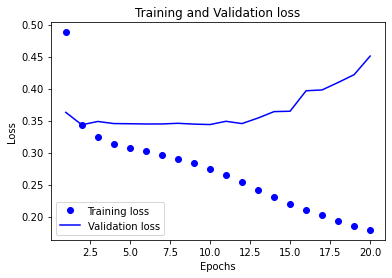

In [35]:
import matplotlib.pyplot as plt

# train_data에 대한 acuuracy
acc = history_dict['accuracy']

# validation data에 대한 accuracy
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

index_epochs = range(1, len(acc)+1)

# "bo"는 파란색 점을 나타냄
plt.plot(index_epochs, loss, 'bo', label = 'Training loss')

# "b"는 파란색 실선을 나타냄
plt.plot(index_epochs, val_loss, 'b', label = 'Validation loss')

# 그래프 제목 달기
plt.title("Training and Validation loss")

# x축 설명
plt.xlabel("Epochs")

# y축
plt.ylabel("Loss")

# 범주 나타냄
plt.legend()

plt.show()




 * 정확도 그래프

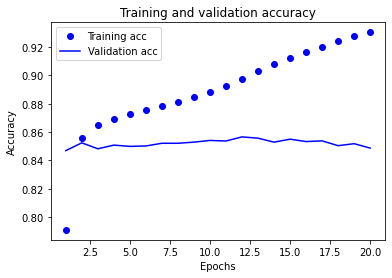

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(index_epochs, acc, 'bo', label='Training acc')
plt.plot(index_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

 * Embedding 레이어를 통해 학습한 파라미터 저장

In [78]:
import os

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_project.txt'
f = open(word2vec_file_path, 'w')  # 경로변수에 저장된 경로, 이름으로 파일 생성됨
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    # ' '.join(리스트) : 문자열을 요소로 같는 시퀀스를 하나의 문자열 형태로 변환, ' '안에 있는 space로 요소간 간격 구분
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [86]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['스토리']
vector

array([ 0.01795136,  0.02765736, -0.00060501, -0.17796525,  0.05553143,
       -0.00102621, -0.12967764, -0.08320764,  0.01762472,  0.04350508,
        0.03435821,  0.03406207, -0.00603202,  0.06729977, -0.01047537,
       -0.08940864], dtype=float32)

 * 주어진 단어에 대하여 모델 안에서 유사단어 추출

In [87]:
word_vectors.similar_by_word("이야기")

[('귀한', 0.8904482126235962),
 ('중', 0.8771058320999146),
 ('호흡', 0.8533762693405151),
 ('근디', 0.8498660326004028),
 ('벅찬', 0.8287866115570068),
 ('마르소', 0.827488899230957),
 ('내심', 0.8235054016113281),
 ('특수', 0.8180931806564331),
 ('원주민', 0.816709041595459),
 ('2002', 0.8128539323806763)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [94]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [96]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [304]:
from tensorflow import keras
from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_75 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_59 (Glo (None, 16)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_146 (Dense)            (None, 8)               

In [305]:
# 학습의 진행
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
2128/2128 [==============================] - 27s 13ms/step - loss: 0.4423 - accuracy: 0.7870 - val_loss: 0.3590 - val_accuracy: 0.8434
Epoch 2/3
2128/2128 [==============================] - 25s 12ms/step - loss: 0.3269 - accuracy: 0.8586 - val_loss: 0.3314 - val_accuracy: 0.8572
Epoch 3/3
2128/2128 [==============================] - 25s 12ms/step - loss: 0.2903 - accuracy: 0.8779 - val_loss: 0.3308 - val_accuracy: 0.8599


In [306]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3414 - accuracy: 0.8532
[0.34140872955322266, 0.853184700012207]


# 결론

    * Word2Vec를 사용하여 정확도 85% 이상을 달성 하였다.
    * 모델의 Dense 레이어를 뒤쪽에 하나 추가하였을때, 정확도가 약간 향샹된 경향을 보였다.
    * 모델 훈련시 batch size를 줄여나갈수록 학습 시간은 오래걸렸지만, 정확도는 향상되었다.
    